In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lumicks import pylake
import re

from scipy.signal import find_peaks, peak_prominences
from lmfit import models

import glob
%matplotlib inline

import pathlib
from tqdm import tqdm_notebook
#= = = = = = FUNCTIONS USED = = = = = = = = = = =
def msd_1d(x): #http://mglerner.com/Optimizing%20MSD%20calculations.html
    result = np.zeros_like(x)
    for i in range(1,len(x)):
        result[i] = np.average((x[i:] - x[:-i])**2)
    return result

def opt_lin_fit(t,msd,pdif): #returns the fit result where the dMSD > some % of prev pt
    if len(t)<3:
        print('not worth fitting')
        return
    lmod=models.LinearModel()
    rchisq=[]
    for i in range(4,len(t),2): #from 1 to whatever, every 3 points
        tempt=t[1:i]
        tempm=msd[1:i]
        result=lmod.fit(tempm,x=tempt,nan_policy='omit')
        rchisq.append(result.redchi) #reduced chi squared
        if len(rchisq)>2: #comparing points
            if abs(rchisq[-2]-rchisq[-1])>(rchisq[-2]*pdif):
                break
    return result

def plotstuff(fr): #plotting the fits etc
    e=len(fr.data)
    plt.figure()
    plt.scatter(tim,m)
    sl=fr.params['slope'].value
    intc=fr.params['intercept'].value
    chsq=fr.redchi
    plt.plot(tim[0:e],tim[0:e]*sl+intc,'b--')
    plt.xlabel('time (s)')
    plt.ylabel('MSD ($nm^2$/s)')
    plt.title('slope=%d, int=%d, X2=%d' %(sl,intc,chsq))

Directory:

In [130]:
#finding files
#seems like having issues with named file formats
k='7'
dire='E:\Olivia files\LAB\PROJECTS\RPA\\190913 ssDNA RPA-DBD\\Kymographs\\'
newf=k+'_saves\\'

pathlib.Path(dire+newf).mkdir(parents=True, exist_ok=True)

filename= glob.glob(dire+'*ph '+ k + '.h5')
file = pylake.File(filename[0])

kymo=file.kymos[k]

pixelsize = kymo.json['scan volume']['scan axes'][0]['pixel size (nm)'] #in nm
pixeltime = kymo.json['scan volume']['pixel time (ms)'] #in ms

Parameters:

In [131]:
bn=3 #bin n frames
icolor=1 #1 is green, 0 is red

#---gaussian fitting
#-decrease sigma if too much random stuff, dataspread=6 is ok
sigmacutoff=0.4 #accept fits with sigma<this
dataspread=4 #how much data from center you're fitting

#---peak finder
#-change height if data is noisy, dist=5 is ok
pkheight=0.4 #need peaks of at least pkheight*MaxIntensity
dbtwnpks=3 #distance from peak to peak

#---group making
#-generally don't change these (close=0.3,length=5)
howclose=0.15 #um; how close are you calling nearby
minlength=5

#--MSD calculations
pmovie=0.15 #minimum percent of movie length for traces

#--combining groups (dont change unless you're sure to combine groups later)
#will automatically change if you run linking part of script
linked=0

Load images and times, and bin

In [132]:
green=kymo.green_image
if icolor!=1:
    green=kymo.red_image 
gtimes=np.array((kymo.timestamps-kymo.timestamps[0,0])/1e9)
gt=np.mean(gtimes,axis=0)

pos=np.arange(len(green))*(pixelsize/1000) #distance in um
rgre=[] #binned green intensities
bnt=[]  #binned times
for i in range(0,len(green[0])-bn+1):
    if i%bn==0:
        vs=np.array(green[:,i])
        ts=gt[i]
        for ib in range(1,bn):
            vs+=np.array(green[:,i+ib])
            ts+=gt[i+ib]
        rgre.append(vs)
        bnt.append(ts/bn)   
rgre=np.array(rgre)

Initialize guesses for peaks:

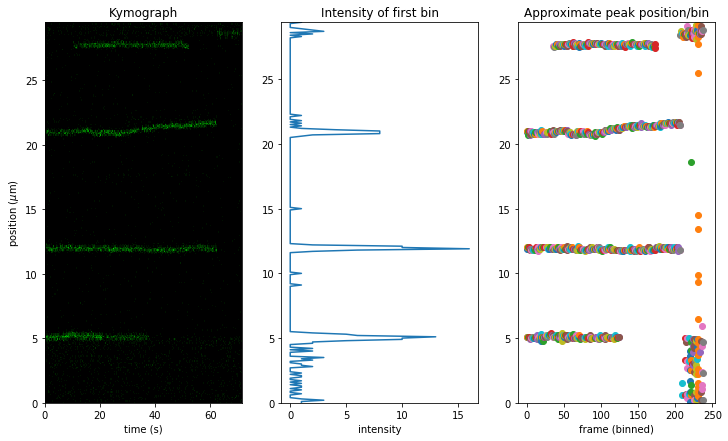

In [133]:
#initial guesses for peaks
plt.figure(figsize=(12,7))

plt.subplot(1,3,3) #find the peaks
pklst=[] #peak position list of each bin
for idx,r in enumerate(rgre):
    peaks,_=find_peaks(r,height=max(r)*pkheight,distance=dbtwnpks)
    pklst.append(peaks)
    plt.scatter([idx]*len(peaks),pos[len(pos)-1]-peaks*(pixelsize/1000)) #CHECK 

plt.xlabel('frame (binned)')
plt.ylim(0,pos[len(pos)-1])
plt.title('Approximate peak position/bin')

plt.subplot(1,3,2)
plt.plot(rgre[0],np.flip(pos))
plt.xlabel('intensity')
plt.ylim(0,pos[len(pos)-1])
plt.title('Intensity of first bin')
#plt.plot(pklst[0],rgre[0][pklst[0]],"x")


plt.subplot(1,3,1)
kymo.plot_green(aspect='auto')
if icolor!=1:
    kymo.plot_red(aspect='auto')    
plt.title('Kymograph');
plt.savefig(dire+newf+'guess-'+k+'.png')

(optional) Check peaks found

In [101]:
#[optional]
n=20 #check peak finding in specific frames
plt.plot(rgre[n])
plt.plot(pklst[n],rgre[n][pklst[n]],"x")
plt.xlabel('Pixel position')
plt.ylabel('Intensity')

print(pklst[n])

IndexError: index 20 is out of bounds for axis 0 with size 1

(optional) Check individual peak fit

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 76
    # data points      = 8
    # variables        = 3
    chi-square         = 2.42131209
    reduced chi-square = 0.48426242
    Akaike info crit   = -3.56105570
    Bayesian info crit = -3.32273107
[[Variables]]
    amplitude:  0.98669353 +/- 0.14155785 (14.35%) (init = 5)
    center:     14.0734361 +/- 0.01280554 (0.09%) (init = 14.1)
    sigma:      0.07714897 +/- 0.01300889 (16.86%) (init = 1)
    fwhm:       0.18167194 +/- 0.03063360 (16.86%) == '2.3548200*sigma'
    height:     5.10225586 +/- 0.73706841 (14.45%) == '0.3989423*amplitude/max(2.220446049250313e-16, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) =  0.582
    C(center, sigma)    =  0.134


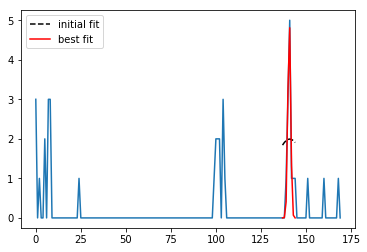

In [7]:
#[optional]
#fit the peak(n) of a specified bin(time)  
bnn=80 #bin
n=3 #peak number

pkpos=pklst[bnn][n] #peak position frame guess
ampguess=rgre[bnn][pkpos] #amplitude guess

#data
x=pos[pkpos-dataspread:pkpos+dataspread]
y=rgre[bnn][pkpos-dataspread:pkpos+dataspread]

gmod=models.GaussianModel()
result=gmod.fit(y,x=x,amplitude=ampguess,center=pos[pkpos],sigma=1)
#print(result.params['amplitude'].value)
#print(result.params['center'].value)
print(result.fit_report())

plt.plot(rgre[bnn])
plt.plot(x*10,result.init_fit,'k--',label='initial fit')
plt.plot(x*10,result.best_fit,'r-',label='best fit')
plt.legend(loc='best');

Fitting everything:

In [134]:
#fit peaks of all bins, output large array of [bin(time) center amplitude]
#this takes a long time and will take forever

my_fits=[]
gmod=models.GaussianModel()

with tqdm_notebook(total=len(rgre)) as pbar:
    for bn,rg in enumerate(rgre):
        pbar.update(1)
        for pkpos in pklst[bn]:
            ampguess=rg[pkpos]
        
            x=pos[pkpos-dataspread:pkpos+dataspread]
            y=rgre[bn][pkpos-dataspread:pkpos+dataspread]
        
            if len(x)==0: #if near image bounds, don't use this peak
                continue
        
            result=gmod.fit(y,x=x,amplitude=ampguess,center=pos[pkpos],sigma=1)
            if result.params['sigma'].value<sigmacutoff: #cutoff the weird errors
                my_fits.append([bn,result.params['center'].value,result.params['amplitude'].value])               

(optional) Check fits

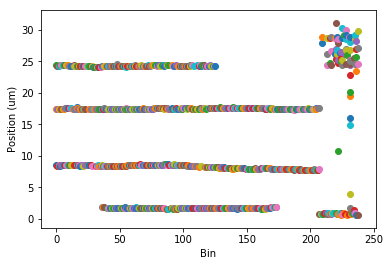

In [135]:
#[optional]
#checking the fits
for ft in my_fits:
    plt.scatter(ft[0],ft[1])
    
plt.ylabel('Position (um)')
plt.xlabel('Bin');

#change these to specific areas you want to look at
#comment if want to see all
#plt.ylim(10.5,13)
#plt.xlim(-5,151);

Make the groups:

In [137]:
%%time
#connecting the dots (making groups)
#OPTION 1
myfits=my_fits.copy() #so don't have to keep re running fitting part
groups=[]

while len(myfits): #each group is array of [bin center amplitude]
    group=[]
    cc=myfits[0]
    group.append(cc)
    myfits.remove(cc)
    for ft in myfits[:]:
        if ft[0]<=cc[0]+2 and np.abs(cc[1]-ft[1])<howclose: #THINGS IN RANGE (some gaps accepted)
            group.append(ft)
            cc=ft
            myfits.remove(ft)
    if len(group)>=minlength: #trajectories have to be at least n frames
        groups.append(group)

Wall time: 0 ns


(optional) plot groups side by side

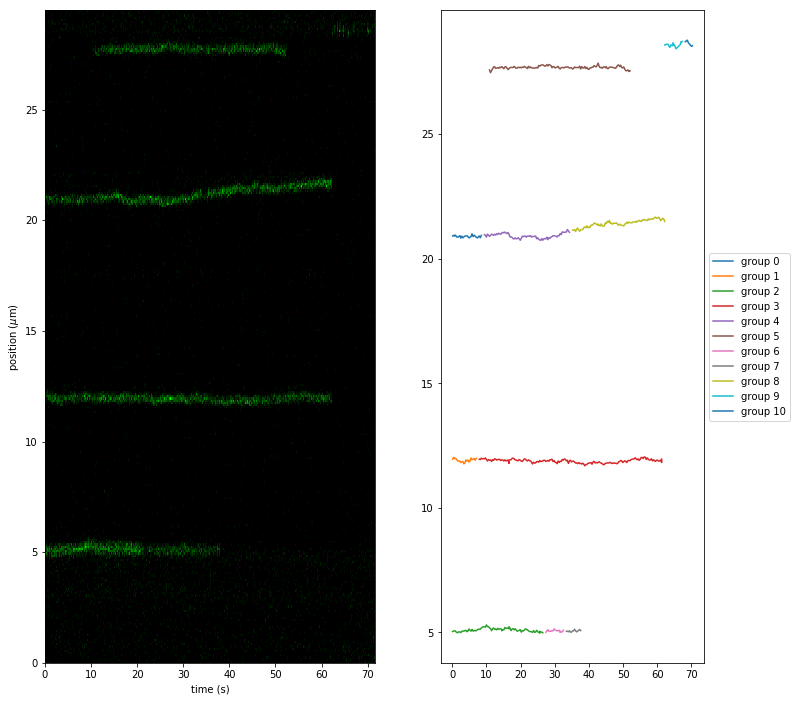

In [138]:
#[optional]
#plot the groups by color (side by side)
fig = plt.figure(figsize=(13,12))
plt.subplot(121)
kymo.plot_green(aspect='auto')
if icolor!=1:
    kymo.plot_red(aspect='auto')
plt.title('');

ax = plt.subplot(122)

for idx,group in enumerate(groups):
    x=[]
    y=[]
    for i in group:
        x.append(bnt[i[0]])
        y.append(i[1])
    plt.plot(x,pos[len(pos)-1]-y,label='group %i'%idx)

#plt.ylabel('position (um)')
#plt.xlabel('frame (bin)');

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

plt.savefig(dire+newf+'trace_besides-unlinked-'+k+'.png', bbox_inches="tight")

(optional) plot groups overlaid on image

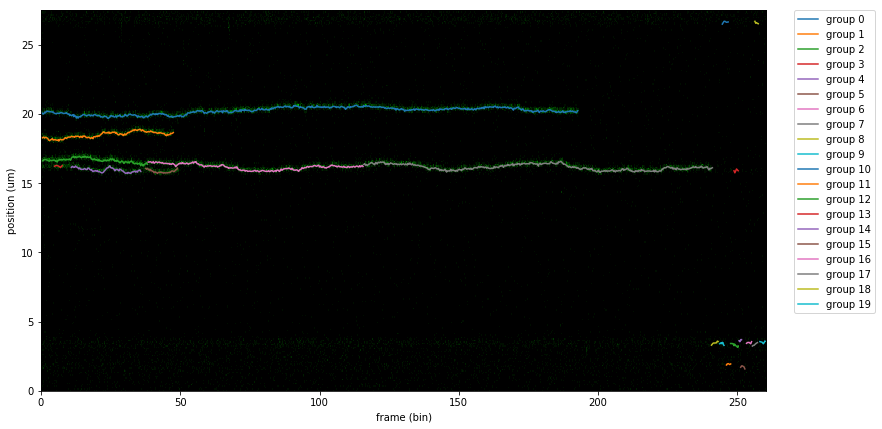

In [55]:
#[optional]
#plot the groups by color (overlaid)
fig = plt.figure(figsize=(13,7))
#plt.subplot(121)
kymo.plot_green(aspect='auto')
if icolor!=1:
    kymo.plot_red(aspect='auto')
plt.title('');

for idx,group in enumerate(groups):
    x=[]
    y=[]
    for i in group:
        x.append(bnt[i[0]])
        y.append(i[1])
    plt.plot(x,pos[len(pos)-1]-y,label='group %i'%idx)


# Put a legend to the right of the current axis
#plt.subplots_adjust(right=0.7)
plt.legend(bbox_to_anchor=(1.15,1), borderaxespad=0);
plt.ylabel('position (um)')
plt.xlabel('frame (bin)');
plt.savefig(dire+newf+'trace_overlay-unlinked-'+k+'.png', bbox_inches="tight")

(optional) combine groups - automatic

Wall time: 328 ms


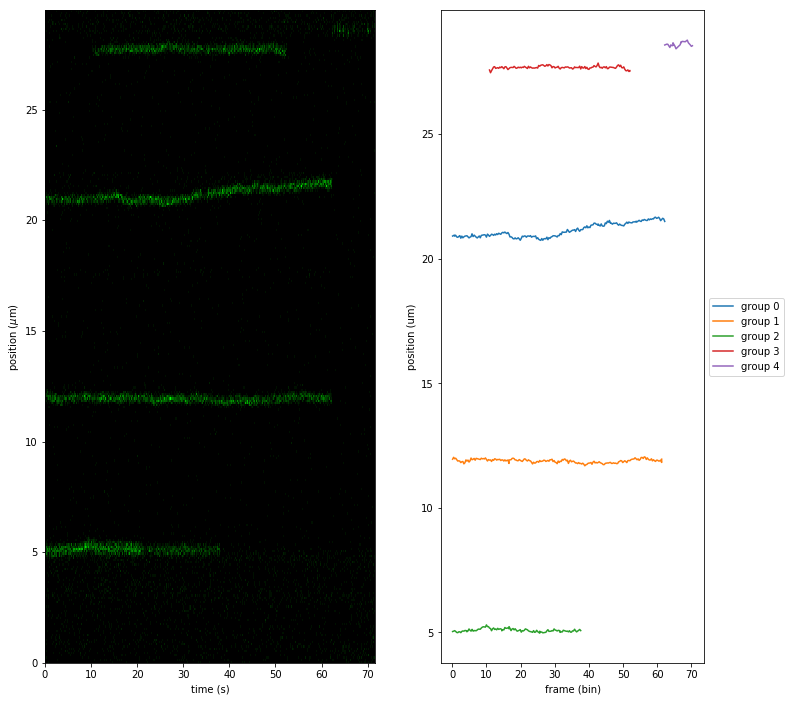

In [139]:
%%time
#[optional]
#decide if want to combine groups
#makes a new list called group2
#if groups are within n bins, and ends are within x distance, combine the groups
groupss=groups.copy()
acceptdist=0.25 #um
binsaway=8 #n+1
linked=1

groups2=[] #this is the combined groups sections

while len(groupss):
    cg=groupss[0]
    groupss.remove(cg)
    for grp in groupss[:]:
        if abs(grp[0][1] - cg[-1][1])<=acceptdist and abs(grp[0][0]-cg[-1][0])<binsaway:
            #print(str(grp[0][0])+' '+str(cg[-1][0]))
            cg = cg+grp
            groupss.remove(grp)
    groups2.append(cg)
    
fig = plt.figure(figsize=(13,12))
plt.subplot(121)
kymo.plot_green(aspect='auto')
if icolor!=1:
    kymo.plot_red(aspect='auto')
plt.title('');

ax = plt.subplot(122)

#plot the groups by color (side by side)
for idx,group in enumerate(groups2):
    x=[]
    y=[]
    for i in group:
        x.append(bnt[i[0]])
        y.append(i[1])
    plt.plot(x,pos[len(pos)-1]-y,label='group %i'%idx)

plt.ylabel('position (um)')
plt.xlabel('frame (bin)');

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

plt.savefig(dire+newf+'trace_besides-linked-'+k+'.png', bbox_inches="tight")

(optional) save data as text

In [140]:
#[optional]
#save your data as txt
if linked==1:
    svfile = []
    for gn,group in enumerate(groups2):
        for i in group:
            t=bnt[i[0]]
            p=pos[len(pos)-1]-i[1]
            rw = [gn,t,p,i[2]] #[group, time, position, intensity]
            svfile.append(rw)
        
    finame=dire+newf+"kymo-traces-linked-"+k+'.txt'
    np.savetxt(finame,svfile)
else:
    svfile = []
    for gn,group in enumerate(groups):
        for i in group:
            t=bnt[i[0]]
            p=pos[len(pos)-1]-i[1]
            rw = [gn,t,p,i[2]] #[group, time, position, intensity]
            svfile.append(rw)
        
    finame=dire+newf+"kymo-traces-"+k+'.txt'
    np.savetxt(finame,svfile)

Zero the trajectories:

4 groups


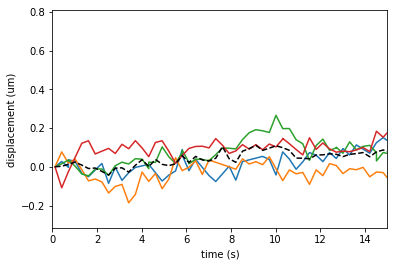

In [141]:
#plot all trajectories zero'd at t=0
maxframes=len(rgre)
if linked==1:    
    svfile = []
    gn=0
    for group in groups2:
        if len(group)>pmovie*maxframes:
            startbin=group[0][0]
            for i in group:
                t=bnt[i[0]-startbin]
                p=pos[len(pos)-1]-i[1]
                rw = [p,t,gn,i[2]] #row is made of [position, time, group index,intensity]
                svfile.append(rw)
            gn+=1
else:
    svfile = []
    gn=0
    for group in groups:
        if len(group)>pmovie*maxframes:
            startbin=group[0][0]
            for i in group:
                t=bnt[i[0]-startbin]
                p=pos[len(pos)-1]-i[1]
                rw = [p,t,gn,i[2]] #row is made of [position, time, group index,intensity]
                svfile.append(rw)  
            gn+=1
            
svfile=np.array(svfile)
ngroups=np.max([i for i in svfile[:,2]])
print('%d groups' %(ngroups+1))

#plot each trajectory
ztraj=[]
for r in range(int(ngroups)+1):
    gr=svfile[svfile[:,2]==r]
    y=gr[:,0]-gr[0,0]
    x=gr[:,1] 
    for i,a in enumerate(y):
        rw=[x[i],a,r]
        ztraj.append(rw)
    plt.plot(x,y)

ztraj=np.array(ztraj)
maxtime=np.max([i for i in ztraj[:,0]])
#mean each timepoint displacement
mdisp=[]
for t in bnt[0:bnt.index(maxtime)]:
    mdt=ztraj[ztraj[:,0]==t]
    if mdt.size==0:
        print('nothing')
        mdt=np.array([[np.nan,np.nan,np.nan]])
    md=np.nanmean(mdt[:,1])
    #print('')
    mdisp.append([t,md])

mdisp=np.array(mdisp)
plt.plot(mdisp[:,0],mdisp[:,1],'k--')
plt.xlabel('time (s)')
plt.ylabel('displacement (um)');
plt.savefig(dire+newf+'all_traces-'+k+'.png')
plt.xlim(0,15);
plt.savefig(dire+newf+'all_traces-closeup-'+k+'.png')

Get MSD of each group:

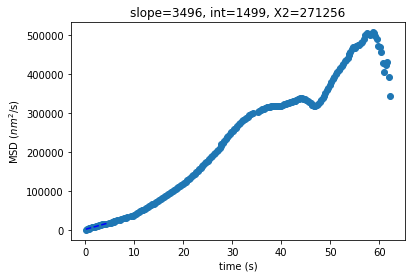

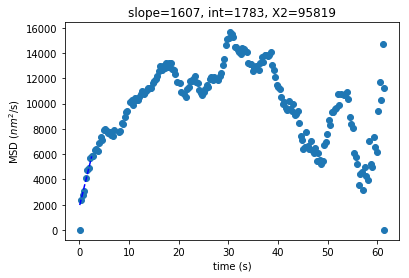

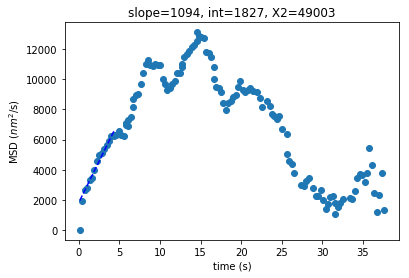

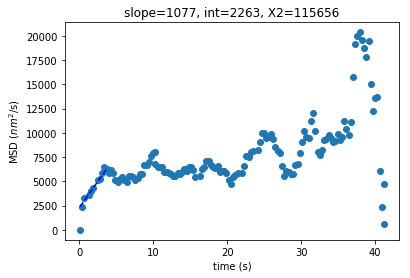

In [142]:
#test
pd=0.4
sv=[] #[slope intercept reducedX2 intensity(mean) intensity(stdev) length(fitted) length(total)]
for r in range(int(ngroups+1)):
    gr=svfile[svfile[:,2]==r]
    pos=gr[:,0]*1000
    tim=gr[:,1]
    amp=np.array(gr[:,3])
    
    m=msd_1d(pos) #MSD
    
    fitr=opt_lin_fit(tim,m,pd) #optimized num points fit result
    if fitr.params['slope'].value>0 and len(fitr.data)>3:
        fig=plt.figure()
        plotstuff(fitr)
        plt.savefig(dire+newf+'msd-indiv-'+k+'-'+str(r)+'.png')
        plt.close(fig) 
        
        one=fitr.params['slope'].value
        two=fitr.params['intercept'].value
        thr=fitr.redchi
        fou=np.mean(amp)
        fiv=np.std(amp)
        six=len(fitr.data)
        sev=len(m)
        sv.append([one,two,thr,fou,fiv,six,sev])

finame=dire+newf+"fit-msds-"+k+'.txt'
np.savetxt(finame,sv)

(optional) statistics on traces:

4 good MSDs


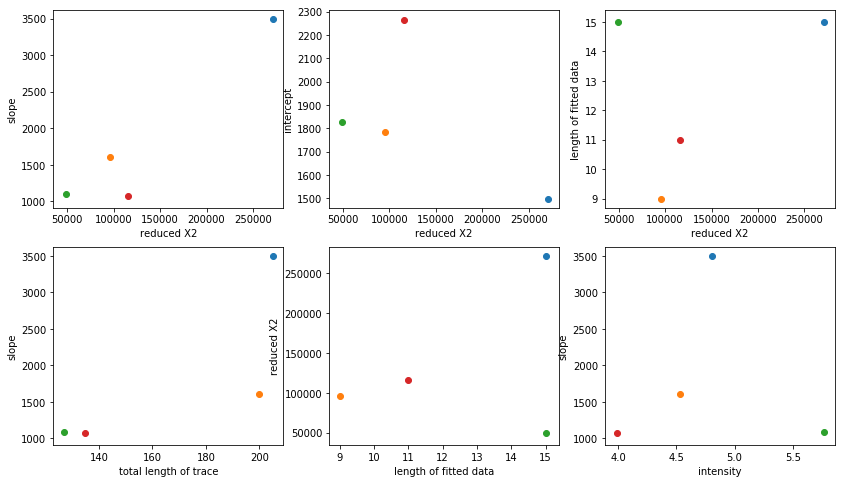

In [143]:
msds=[] #each MSD
plt.figure(figsize=(14,8))
for r in range(int(ngroups+1)):
    gr=svfile[svfile[:,2]==r]
    pos=gr[:,0]*1000
    tim=gr[:,1]
    amp=gr[:,3]
    
    m=msd_1d(pos) #MSD
    
    fitr=opt_lin_fit(tim,m,pd) #optimized num points fit result
    if fitr.params['slope'].value>0 and len(m)>5:
        plt.subplot(231)
        plt.scatter(fitr.redchi,fitr.params['slope'].value)
        plt.xlabel('reduced X2')
        plt.ylabel('slope')
        plt.subplot(232)
        plt.scatter(fitr.redchi,fitr.params['intercept'].value)
        plt.xlabel('reduced X2')
        plt.ylabel('intercept')
        plt.subplot(233)
        plt.scatter(fitr.redchi,len(fitr.data))
        plt.xlabel('reduced X2')
        plt.ylabel('length of fitted data')
        plt.subplot(234)
        plt.scatter(len(m),fitr.params['slope'].value)
        plt.xlabel('total length of trace')
        plt.ylabel('slope')
        plt.subplot(235)
        plt.scatter(len(fitr.data),fitr.redchi)
        plt.ylabel('reduced X2')
        plt.xlabel('length of fitted data')
        plt.subplot(236)
        plt.scatter(sum(amp)/len(amp),fitr.params['slope'].value)
        plt.xlabel('intensity')
        plt.ylabel('slope')
        #plotstuff(fitr)
        msds.append(m)
    
print(str(len(msds))+' good MSDs')

plt.savefig(dire+newf+'msd-outputs-'+k+'.png')

Get MSD of average of all groups: (doesn't save)

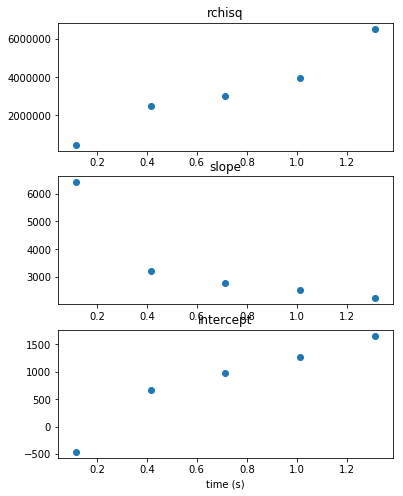

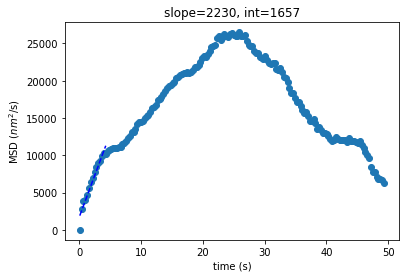

In [23]:
mm=msd_1d(mdisp[:,1]*1000)
tt=mdisp[:,0]

plt.figure(figsize=(6,8))
def opt_lin_fit(t,msd):
    if len(t)<3:
        print('not worth fitting')
        return
    lmod=models.LinearModel()
    rchisq=[]
    slp=[]
    intcpt=[]
    for i in range(3,200,3):
        tempt=t[0:i]
        tempm=msd[0:i]
        result=lmod.fit(tempm,x=tempt,nan_policy='omit')
        rchisq.append(result.chisqr)
        slp.append(result.params['slope'].value)
        intcpt.append(result.params['intercept'].value)
        if len(rchisq)>2:
            if abs(rchisq[-2]-rchisq[-1])>(rchisq[-2]*0.4):
                break
    plt.subplot(311)
    plt.scatter(t[0:len(rchisq)],rchisq)
    plt.title('rchisq')
    plt.subplot(312)
    plt.scatter(t[0:len(slp)],slp)
    plt.title('slope')
    plt.subplot(313)
    plt.scatter(t[0:len(intcpt)],intcpt)
    plt.title('intercept')
    return result


r=opt_lin_fit(tt,mm)
plt.xlabel('time (s)')

e=len(r.data)
ee=e+150
plt.figure()
plt.scatter(tt[0:ee],mm[0:ee])
sl=r.params['slope'].value
intc=r.params['intercept'].value
plt.plot(tt[0:e],tt[0:e]*sl+intc,'b--')
plt.xlabel('time (s)')
plt.ylabel('MSD ($nm^2$/s)')
plt.title('slope=%d, int=%d' %(sl,intc));

## Random code testing area

In [414]:
#how to go through a loop that removes things from list
a=[1,2,3,4,5,6,7,8,9]
while len(a):
    print(a)
    for i in a[:]:
        if random.random() > 0.5:
            print("removing: %d" % i)
            a.remove(i)
        else:
            print("keeping: %d"  % i)

[1, 2, 3, 4, 5, 6, 7, 8, 9]
keeping: 1
removing: 2
removing: 3
keeping: 4
removing: 5
keeping: 6
removing: 7
removing: 8
removing: 9
[1, 4, 6]
removing: 1
removing: 4
keeping: 6
[6]
removing: 6


In [948]:
x=np.array([[1,2,3],[4,5,6],[7,8,9]])
print(x[0:int(0.7*len(x))])

[[1 2 3]
 [4 5 6]]


In [124]:
x=np.array([[1,2,3],[4,5,6],[7,8,9]])
print(x[-1][1])

8


In [18]:
x=[[1,2,3],[4,5,6],[7,8,9]]
#np.concatenate((x,x),axis=0)
a=x[0]
x.remove(a)
print(a)

[1, 2, 3]


In [93]:
x=np.array([[1,2,3],[4,5,6],[7,8,9]])
for b in x[:,0]:
    print(b)

1
4
7


In [18]:
x=[1,2,3,4,5]
print(x[1:-1])

[2, 3, 4]


In [38]:
x=[[1,2,3]]
print(x[-1][0])

1


In [122]:
x=np.array([0,1,2,3,4,5])
for n in x[x>3]:
    print(n)

4
5
